In [ ]:
# %%

os.chdir("C:/Users/aladesuru/Documents/DataAnalysis/Lab/Niedersachsen")

from src.data import dataload as dl

gld = dl.load_data(loadExistingData = True)

2024-09-29 11:13:48,392 - INFO - Loaded existing data from data\interim\gld_20240818.pkl


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10808236 entries, 0 to 10808235
Data columns (total 13 columns):
 #   Column      Dtype   
---  ------      -----   
 0   FLIK        object  
 1   year        int32   
 2   kulturcode  int32   
 3   geometry    geometry
 4   area_m2     float64 
 5   area_ha     float64 
 6   peri_m      float64 
 7   par         float64 
 8   cpar        float64 
 9   shp_index   float64 
 10  fract       float64 
 11  CELLCODE    object  
 12  LANDKREIS   object  
dtypes: float64(7), geometry(1), int32(2), object(3)
memory usage: 989.5+ MB


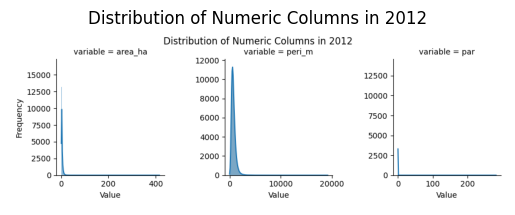

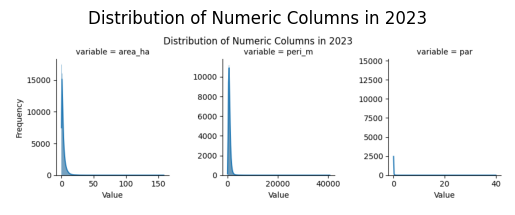

In [ ]:
# %% get a feel of the data ###

############################
# 1. print info to learn about the total number of entries (len(gld)), data types and presence/ number of missing values
gld.info() 

# 2. create a copy removing FLIK, area_m2, cpar, shp_index, fract
# and making kulturcode, CELLCODE and LANDKREIS nominal
def copy_data(data):
    data = data.drop(columns=['FLIK', 'area_m2', 'cpar','shp_index', 'fract'])
    data['kulturcode'] = data['kulturcode'].astype('category')
    data['CELLCODE'] = data['CELLCODE'].astype('category')
    data['LANDKREIS'] = data['LANDKREIS'].astype('category')
    return data
data = copy_data(gld)

# 3. examine data distribution (perhaps for outliers)
# 3.1. take two representative years, 1st and last and create distribution plots for
# numeric columns
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def distribution_plots(df):
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Group by year and create distribution plots for numeric columns in a FacetGrid
    for year, group in df.groupby('year'):
        plot_file = f'reports/distribution_plots_{year}.png'
        
        if os.path.exists(plot_file):
            # Load and display the plot from the file
            img = plt.imread(plot_file)
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(f'Distribution of Numeric Columns in {year}')
            plt.show()
        else:
            # Create a FacetGrid for the current year
            g = sns.FacetGrid(pd.melt(group, id_vars=['year'], value_vars=numeric_columns), col='variable', col_wrap=3, sharex=False, sharey=False)
            g.map(sns.histplot, 'value', kde=True)
            
            # Set titles and labels
            g.fig.suptitle(f'Distribution of Numeric Columns in {year}', y=1.02)
            g.set_axis_labels('Value', 'Frequency')
            
            # Save the FacetGrid plot
            g.savefig(plot_file)
            plt.show()
# Filter the DataFrame to include only the years 2012 and 2023
filtered_data = data[data['year'].isin([2012, 2023])]
distribution_plots(filtered_data)
#  the data has a long right tail which suggests the presence of outliers

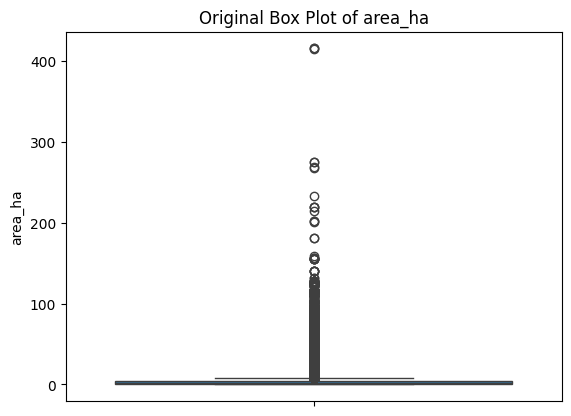

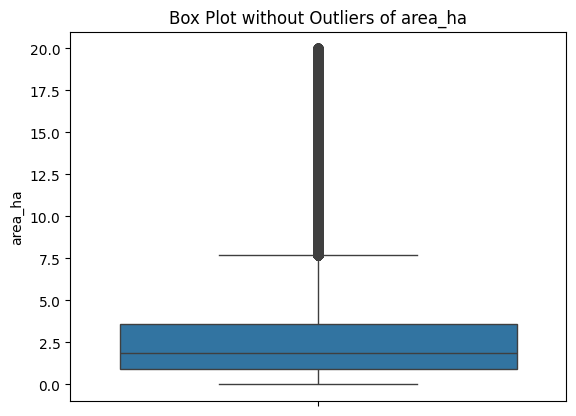

Q1: 0.8872548255682493, Q2: 1.8696008069327865, Q3: 3.616512119185599, Q4: 7.665457775329066


In [ ]:
# %% 3.2 plot box plot with and without outliers so as to get the outlier threshold

# we use area_ha as the control column
def box_plot(df, column):
    sns.boxplot(df[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()
    
box_plot(data, 'area_ha')

def datatrim_box_plot(df, column, threshold):
    data_trim = df[df[column] <= threshold]

    sns.boxplot(data_trim[column])
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    
    # Calculate quartile
    Q1 = data_trim['area_ha'].quantile(0.25)
    Q2 = data_trim['area_ha'].quantile(0.50)
    Q3 = data_trim['area_ha'].quantile(0.75)
    Q4 = data_trim['area_ha'].quantile(0.935)
    
    # print the quartiles
    print(f"Q1: {Q1}, Q2: {Q2}, Q3: {Q3}, Q4: {Q4}")
    return data_trim

threshold_value = 20
data_trim = datatrim_box_plot(data, 'area_ha', threshold_value)
# from the box plot, the threshold value can be set at 20 and
# we can use 0, 1, 2, 4, 6, 8, 10, 20, as bins for understanding area distribution

In [ ]:
# %%

# Calculate the percentage difference between len(data) and len(data_trim)
def calculate_percentage_difference(original_len, trimmed_len):
    percentage_difference = ((original_len - trimmed_len) / original_len) * 100
    return percentage_difference

original_len = len(data)
trimmed_len = len(data_trim)
percentage_difference = calculate_percentage_difference(original_len, trimmed_len)

print(f"Percentage difference between len(data) and len(data_trim): {percentage_difference:.2f}%")

Percentage difference between len(data) and len(data_trim): 0.38%


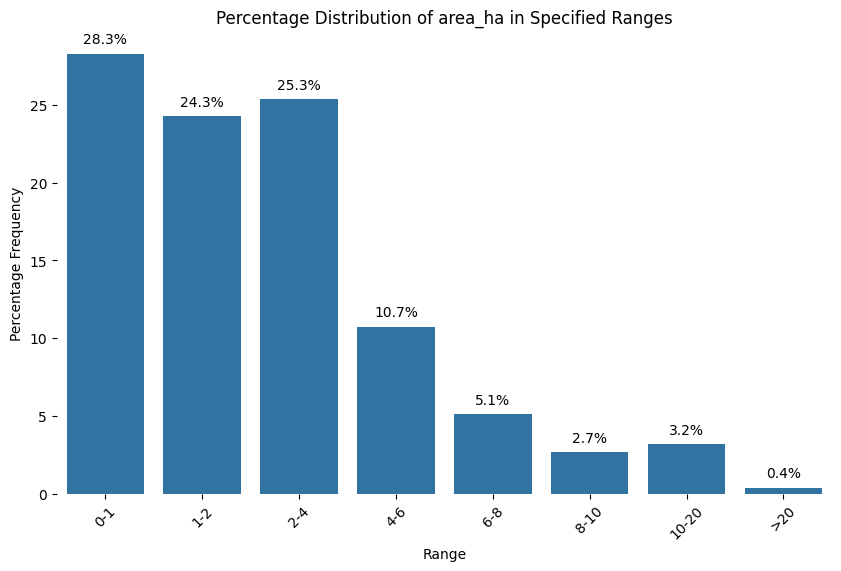

In [ ]:
# %% 3.3 create a bar plot of the percentage distribution of area_ha in specified ranges

# to get a better understanding of the data distribution with and without outliers
def bar_plot(data, column):
    # Define the bins and labels
    bins = [0, 1, 2, 4, 6, 8, 10, 20, float('inf')]
    labels = ['0-1', '1-2', '2-4', '4-6', '6-8', '8-10', '10-20', '>20']

    # Bin the data
    data[f'{column}_binned'] = pd.cut(data[column], bins=bins, labels=labels, right=False)

    # Calculate percentage frequency using the dynamically named binned column
    percentage_frequency = data[f'{column}_binned'].value_counts(normalize=True) * 100
    percentage_frequency = percentage_frequency.reindex(labels)  # Ensure the order matches the labels

    # Create the percentage frequency bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=percentage_frequency.index, y=percentage_frequency.values)
    plt.title(f'Percentage Distribution of {column} in Specified Ranges')
    plt.xlabel('Range')
    plt.ylabel('Percentage Frequency')
    plt.grid(False)
    plt.xticks(rotation=45)

    # Remove the top and right spines
    sns.despine(left=True, bottom=True)

    # Add labels to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.show()

# Example usage
bar_plot(data, 'area_ha')
#data_trim.info()

In [ ]:
data_trim.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 10766702 entries, 0 to 10808235
Data columns (total 9 columns):
 #   Column          Dtype   
---  ------          -----   
 0   year            int32   
 1   kulturcode      category
 2   geometry        geometry
 3   area_ha         float64 
 4   peri_m          float64 
 5   par             float64 
 6   CELLCODE        category
 7   LANDKREIS       category
 8   area_ha_binned  category
dtypes: category(4), float64(3), geometry(1), int32(1)
memory usage: 513.4 MB


In [ ]:
data_trim.head()

,year,kulturcode,geometry,area_ha,peri_m,par,CELLCODE,LANDKREIS,area_ha_binned
0,2012,452,"POLYGON ((586867.422 5897421.974, 586647.781 5...",1.570343,578.467014,0.036837,10kmE434N334,Lüneburg,1-2
1,2012,910,"POLYGON ((553668.492 5875236.581, 553684.023 5...",0.024520,123.057997,0.501874,10kmE430N332,Heidekreis,0-1
2,2012,115,"POLYGON ((428044.838 5941127.279, 428044.115 5...",1.086383,440.057366,0.040507,10kmE418N339,Friesland,1-2
3,2012,131,"POLYGON ((462855.306 5854847.84, 462754.791 58...",0.367863,283.778694,0.077143,10kmE421N330,Oldenburg,0-1
4,2012,452,"POLYGON ((604705.953 5858831.705, 604729.937 5...",0.241342,227.650693,0.094327,10kmE435N330,Uelzen,0-1


In [ ]:
# %% 4.  yearly exploration of the data without outliers (i.e., use data_trim)

# 4.1. group data by year and count the unique values in the non-numeric columns
# Identify non-numeric columns
def count_unique(data):
    category_columns = data.select_dtypes(include=['category']).columns
    # Exclude 'area_ha_binned'
    category_columns = category_columns.drop('area_ha_binned', errors='ignore')
    # Group by year and count unique values in non-numeric columns
    unique_counts_by_year = gld.groupby('year')[category_columns].nunique()
    # Print the unique counts
    print("Unique counts in non-numeric columns by year:")
    print(unique_counts_by_year)
count_unique(data_trim)

Unique counts in non-numeric columns by year:
      kulturcode  CELLCODE  LANDKREIS
year                                 
2012         125       569         46
2013         122       569         46
2014         124       569         46
2015         202       569         46
2016         213       570         46
2017         221       569         46
2018         221       570         46
2019         227       570         46
2020         231       570         46
2021         239       569         46
2022         239       569         46
2023         247       569         46


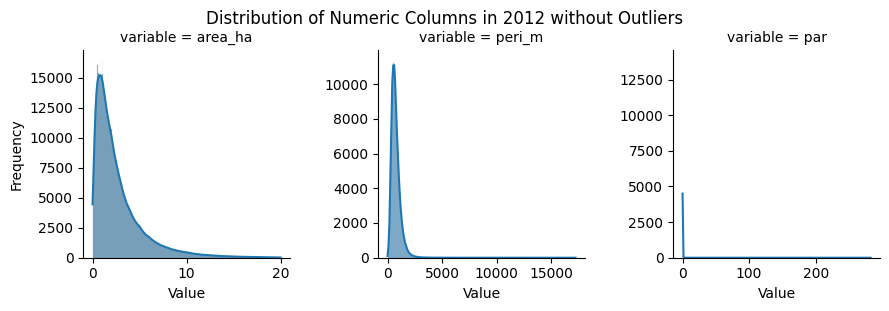

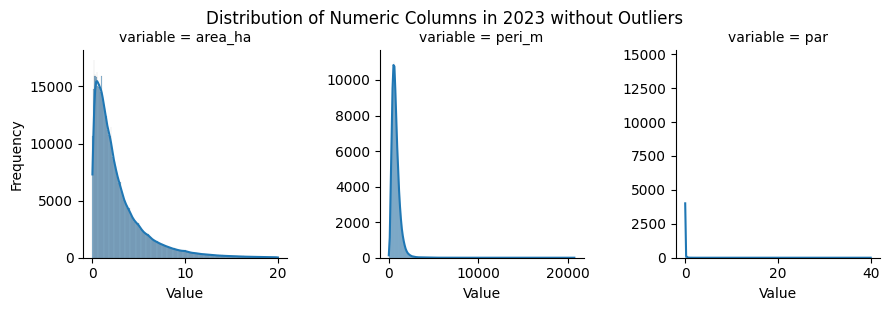

In [ ]:
# %% 4.3. replot the distribution plots for the numeric columns

def distribution_plots(df):
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Group by year and create distribution plots for numeric columns in a FacetGrid
    for year, group in df.groupby('year'):
        plot_file = f'reports/trimmed_distribution_plots_{year}.png'
        
        if os.path.exists(plot_file):
            # Load and display the plot from the file
            img = plt.imread(plot_file)
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(f'Distribution of Numeric Columns in {year} without Outliers')
            plt.show()
        else:
            # Create a FacetGrid for the current year
            g = sns.FacetGrid(pd.melt(group, id_vars=['year'], value_vars=numeric_columns), col='variable', col_wrap=3, sharex=False, sharey=False)
            g.map(sns.histplot, 'value', kde=True)
            
            # Set titles and labels
            g.fig.suptitle(f'Distribution of Numeric Columns in {year} without Outliers', y=1.02)
            g.set_axis_labels('Value', 'Frequency')
            
            # Save the FacetGrid plot
            g.savefig(plot_file)
            plt.show()
# Filter the DataFrame to include only the years 2012 and 2023
filtered_data = data_trim[data_trim['year'].isin([2012, 2023])]
distribution_plots(filtered_data)

In [ ]:
# %% 3.5. Test for normal distribution

from scipy.stats import shapiro

# Group by year and perform normality tests for numeric columns
normality_results = {}
numeric_columns = data_trim.select_dtypes(include=['number']).columns
for year, group in data_trim.groupby('year'):
    normality_results[year] = {}
    for column in numeric_columns:
        stat, p_value = shapiro(group[column].dropna())
        normality_results[year][column] = {'statistic': stat, 'p_value': p_value}

# Print the normality test results
print("Normality test results (Shapiro-Wilk) for numeric columns by year:")
for year, results in normality_results.items():
    print(f"\nYear: {year}")
    for column, result in results.items():
        print(f"  Column: {column}, Statistic: {result['statistic']:.4f}, P-value: {result['p_value']:.4f}")

c:\Users\aladesuru\.virtualenvs\Niedersachsen-mT1qFFaD\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\aladesuru\.virtualenvs\Niedersachsen-mT1qFFaD\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 919304.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\aladesuru\.virtualenvs\Niedersachsen-mT1qFFaD\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 909658.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\aladesuru\.virtualenvs\Niedersachsen-mT1qFFaD\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 905104.
  res = hypotest

Normality test results (Shapiro-Wilk) for numeric columns by year:

Year: 2012
  Column: year, Statistic: 1.0000, P-value: 1.0000
  Column: area_ha, Statistic: 0.7829, P-value: 0.0000
  Column: peri_m, Statistic: 0.8595, P-value: 0.0000
  Column: par, Statistic: 0.0189, P-value: 0.0000

Year: 2013
  Column: year, Statistic: 1.0000, P-value: 1.0000
  Column: area_ha, Statistic: 0.7841, P-value: 0.0000
  Column: peri_m, Statistic: 0.8614, P-value: 0.0000
  Column: par, Statistic: 0.0741, P-value: 0.0000

Year: 2014
  Column: year, Statistic: 1.0000, P-value: 1.0000
  Column: area_ha, Statistic: 0.7843, P-value: 0.0000
  Column: peri_m, Statistic: 0.8597, P-value: 0.0000
  Column: par, Statistic: 0.0773, P-value: 0.0000

Year: 2015
  Column: year, Statistic: 1.0000, P-value: 1.0000
  Column: area_ha, Statistic: 0.7827, P-value: 0.0000
  Column: peri_m, Statistic: 0.8602, P-value: 0.0000
  Column: par, Statistic: 0.1442, P-value: 0.0000

Year: 2016
  Column: year, Statistic: 1.0000, P-valu

Correlation matrix:
             year   area_ha    peri_m       par
year     1.000000  0.007678  0.014557  0.006107
area_ha  0.007678  1.000000  0.765990 -0.041023
peri_m   0.014557  0.765990  1.000000 -0.028360
par      0.006107 -0.041023 -0.028360  1.000000


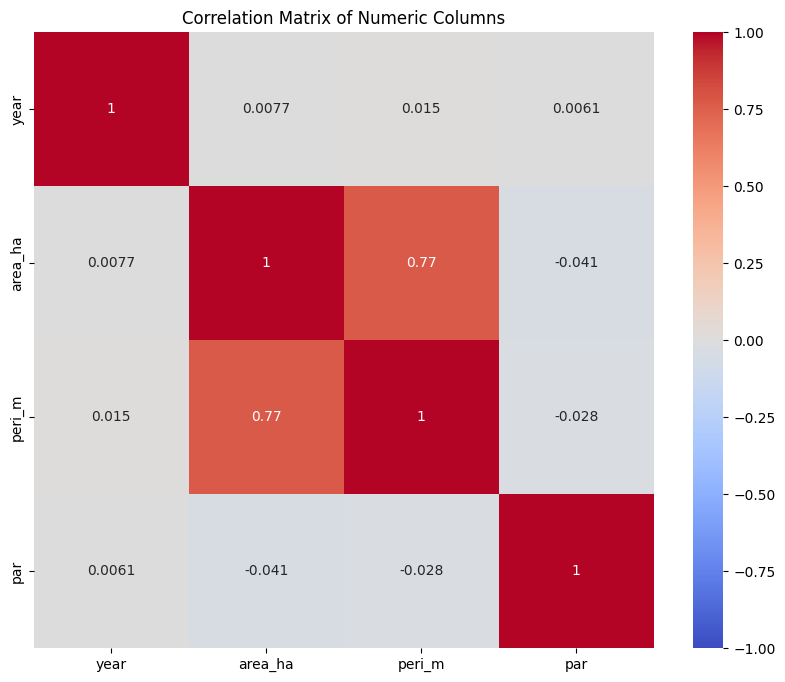

In [ ]:
# %% 4.5. Test for correlation between numeric columns

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def test_correlation(df):
    # Select numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns
    
    # Calculate correlation matrix
    correlation_matrix = df[numeric_columns].corr()
    
    # Print the correlation matrix
    print("Correlation matrix:")
    print(correlation_matrix)
    
    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Numeric Columns')
    plt.show()

# Example usage
test_correlation(data_trim)